We gather inspiration from the `nbodykit` cookbooks 

In [46]:
from nbodykit.lab import *
from nbodykit import setup_logging, style

from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
plt.style.use(style.notebook)

from astropy.io import fits
import numpy as np

setup_logging()

In [47]:
with fits.open("../data/galaxy_DR12v5_CMASS_North.fits") as hdul:
    thead, tdata = hdul[1].header, hdul[1].data
    print(tdata.shape)
    
with fits.open("../data/galaxy_DR12v5_CMASS_South.fits") as hdul:
    tdata = np.append(tdata, hdul[1].data)
    print(hdul[1].data.shape)
    print(tdata.shape)
    
with fits.open("../data/random0_DR12v5_CMASS_North.fits") as hdul:
    rhead, rdata = hdul[1].header, hdul[1].data
    print(rdata.shape)
    
with fits.open("../data/random0_DR12v5_CMASS_South.fits") as hdul:
    rdata = np.append(rdata, hdul[1].data)
    print(hdul[1].data.shape)
    print(rdata.shape)

(618806,)
(230831,)
(849637,)
(32151741,)
(11636252,)
(43787993,)


In [48]:
data = ArrayCatalog(tdata)
randoms = ArrayCatalog(rdata)

ZMIN, ZMAX = 0.43, 0.7

valid = (data['Z'] > ZMIN) & (data['Z'] < ZMAX)
data = data[valid]

valid = (randoms['Z'] > ZMIN) & (randoms['Z'] < ZMAX)
randoms = randoms[valid]

In [49]:
# the fiducial BOSS DR12 cosmology
cosmo = cosmology.Cosmology(h=0.674).match(Omega0_m=0.315)

# add Cartesian position column
data['Position'] = transform.SkyToCartesian(data['RA'], data['DEC'], data['Z'], cosmo=cosmo)
randoms['Position'] = transform.SkyToCartesian(randoms['RA'], randoms['DEC'], randoms['Z'], cosmo=cosmo)

In [50]:
randoms['WEIGHT'] = 1.0
data['WEIGHT'] = data['WEIGHT_SYSTOT'] * (data['WEIGHT_NOZ'] + data['WEIGHT_CP'] - 1.0)

In [51]:
# combine the data and randoms into a single catalog
fkp = FKPCatalog(data, randoms)

In [52]:
mesh = fkp.to_mesh(Nmesh=256, nbar='NZ', fkp_weight='WEIGHT_FKP', comp_weight='WEIGHT', window='tsc')

[ 000149.14 ]   0: 12-05 04:01  FKPCatalog      INFO     cartesian coordinate range: [-1741.73402875 -1605.77852982  -330.77628953] : [1741.63572054 1524.17168703 1621.95345538]
[ 000149.14 ]   0: 12-05 04:01  FKPCatalog      INFO     BoxSize = [3554. 3193. 1992.]
[ 000149.14 ]   0: 12-05 04:01  FKPCatalog      INFO     BoxCenter = [-4.91541055e-02 -4.08034214e+01  6.45588583e+02]


In [53]:
# compute the multipoles
r = ConvolvedFFTPower(mesh, poles=[0,2,4], dk=0.005, kmin=0.)

for key in r.attrs:
    print("%s = %s" % (key, str(r.attrs[key])))

[ 000149.16 ]   0: 12-05 04:01  ConvolvedFFTPower INFO     using compensation function CompensateTSCShotnoise for source 'first'
[ 000149.16 ]   0: 12-05 04:01  ConvolvedFFTPower INFO     using compensation function CompensateTSCShotnoise for source 'second'
[ 000261.72 ]   0: 12-05 04:03  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 777202 
[ 000263.23 ]   0: 12-05 04:03  CatalogMesh     INFO     painted 777202 out of 777202 objects to mesh
[ 000263.26 ]   0: 12-05 04:03  CatalogMesh     INFO     painted 777202 out of 777202 objects to mesh
[ 000263.26 ]   0: 12-05 04:03  CatalogMesh     INFO     mean particles per cell is 0.0138325
/home2/shubh/.conda/envs/cosmo/lib/python3.8/logging/__init__.py:373: ComplexWarning: Casting complex values to real discards the imaginary part
  msg = msg % self.args
[ 000263.26 ]   0: 12-05 04:03  CatalogMesh     INFO     sum is 232071 
[ 000263.26 ]   0: 12-05 04:03  FKPCatalogMesh  INFO     data painted.
[ 000263.53 ]   0: 12-05 04:03  CatalogMesh   

poles = [0, 2, 4]
dk = 0.005
kmin = 0.0
kmax = None
Nmesh = [256 256 256]
BoxSize = [3554. 3193. 1992.]
BoxPad = [0.02 0.02 0.02]
BoxCenter = [-4.91541055e-02 -4.08034214e+01  6.45588583e+02]
mesh.resampler = tsc
mesh.interlaced = False
alpha = 0.020742209563797524
data.norm = 15.771836
randoms.norm = 15.770034948667565
shotnoise = 5655.635211612071
data.N = 777202
data.W = 831696.06
data.W2 = 87647.5703125
data.num_per_cell = 0.013832508586347103
randoms.N = 40096792
randoms.W = 40096792.0
randoms.W2 = 3584039.8204946877
randoms.num_per_cell = 0.6667918625300073


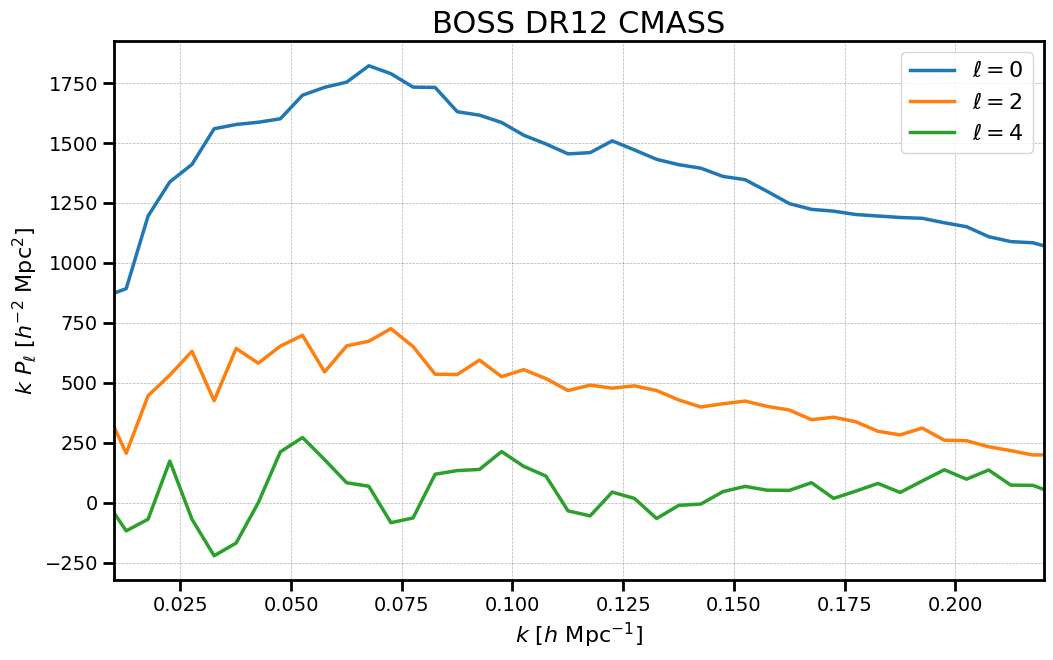

In [54]:
poles = r.poles

psmodes = {}

for ell in [0, 2, 4]:
    label = r'$\ell=%d$' % (ell)
    P = poles['power_%d' %ell].real
    if ell == 0: P = P - r.attrs['shotnoise']
    psmodes[ell] = P
    plt.plot(poles['k'], poles['k']*P, label=label)

# format the axes
plt.legend(loc=0)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$k \ P_\ell$ [$h^{-2} \ \mathrm{Mpc}^2$]")
plt.title('BOSS DR12 CMASS')
plt.xlim(0.01, 0.22)
plt.show()
plt.close()

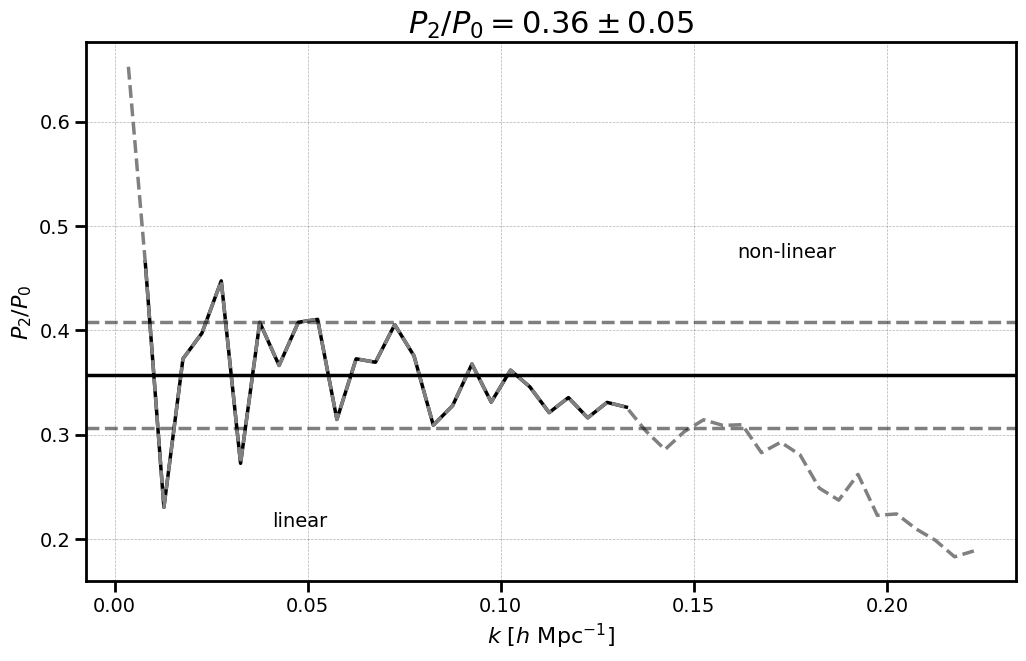

(0.35734653, 0.050770782)

In [55]:
ratio = (psmodes[2] / psmodes[0])[1:-18]
b, sb = np.mean(ratio), np.std(ratio)

plt.plot(poles['k'][1:-18], ratio, ls='-', color='k')
plt.plot(poles['k'], psmodes[2] / psmodes[0], ls='--', color='grey')
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P_2 / P_0$")
plt.axhline(b, color='k', ls='-')
plt.axhline(b + sb, color='k', ls='--', alpha=0.5)
plt.axhline(b - sb, color='k', ls='--', alpha=0.5)
plt.title(r"$P_2/P_0 = %.2f \pm %.2f$" % (b, sb))
plt.text(0.2, 0.1, r"linear", transform=plt.gca().transAxes)
plt.text(0.7, 0.6, r"non-linear", transform=plt.gca().transAxes)
plt.grid(True)
plt.show()
plt.close()
    
b, sb